In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path1 = '/content/drive/MyDrive/Fakenewsnet/politifact_real.csv'
fake_path1 = '/content/drive/MyDrive/Fakenewsnet/politifact_fake.csv'
true_path2 = '/content/drive/MyDrive/Fakenewsnet/PolitiFact_real_news_content.csv'
fake_path2 = '/content/drive/MyDrive/Fakenewsnet/PolitiFact_fake_news_content.csv'

true_df1 = pd.read_csv(true_path1)
fake_df1 = pd.read_csv(fake_path1)
true_df2 = pd.read_csv(true_path2)
fake_df2 = pd.read_csv(fake_path2)

true_df1['label'] = 1
fake_df1['label'] = 0
true_df2['label'] = 1
fake_df2['label'] = 0
df1 = pd.concat([true_df1, fake_df1])
df2 = pd.concat([true_df2, fake_df2])
df1 = df1[~df1['title'].isna()][['title','label']]
df2 = df2[~df2['title'].isna()][['title','label']]

df = pd.concat([df1, df2])
display(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,label
0,National Federation of Independent Business,1
1,comments in Fayetteville NC,1
2,"Romney makes pitch, hoping to close deal : Ele...",1
3,Democratic Leaders Say House Democrats Are Uni...,1
4,"Budget of the United States Government, FY 2008",1
...,...,...
115,"Donald Trump, Germany’s disfavored son – POLITICO",0
116,BREAKING: Hollywood Legend Just Died Of Terrib...,0
117,Worst. President. Ever.,0
118,Don King drops N-word while introducing Donald...,0


,title,label
0,05/27/99 Committee on the Judiciary,1
1,Clinton Body Count Series #5: Woman Set to Tes...,0
2,McConnell punts budget vote to buy time for deal,0
3,"""One Hundred Percent"" by Club for Growth Action",1
4,'This Week' Transcript: Adm. Mike Mullen,1
...,...,...
1291,Covering Young Adults Under the Affordable Car...,1
1292,Lisa Page Squeals: DNC Server Was Not Hacked B...,0
1293,Gretchen Carlson: “The 2nd Amendment Was Writt...,0
1294,Court Orders Obama To Pay $400 Million In Rest...,0


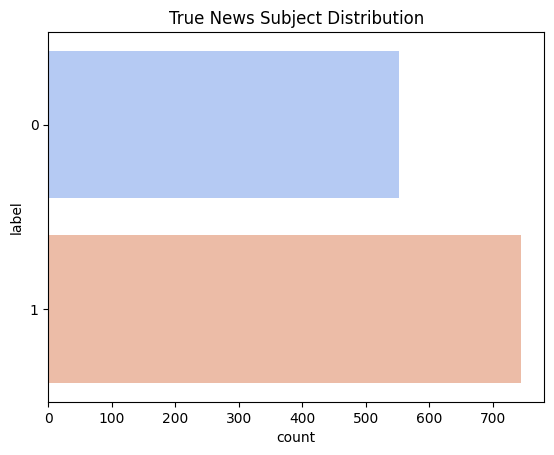

In [2]:
from sklearn.utils import shuffle

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1296 non-null   object
 1   label   1296 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [4]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 1295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1097 non-null   object
 1   label   1097 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.7+ KB


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [7]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 1097
Max length of the titles: 35
Mean length of the titles: 7.082953509571559
Median length of the titles: 7.0


In [8]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(list_of_words)

sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
l2_reg = 0.01
optimizer = Adam(lr=0.01)
embedding_vector_features=60
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
# model.add(LSTM(100))
model.add(Bidirectional(LSTM(100, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['label'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


Epoch 1/5
12/12 [==============================] - 12s 104ms/step - loss: 3.6925 - accuracy: 0.5359 - val_loss: 2.4268 - val_accuracy: 0.6364
Epoch 2/5
12/12 [==============================] - 0s 14ms/step - loss: 2.1153 - accuracy: 0.8214 - val_loss: 2.0067 - val_accuracy: 0.7182
Epoch 3/5
12/12 [==============================] - 0s 15ms/step - loss: 1.3977 - accuracy: 0.9700 - val_loss: 1.5482 - val_accuracy: 0.7727
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.9136 - accuracy: 0.9909 - val_loss: 1.1884 - val_accuracy: 0.7818
Epoch 5/5
12/12 [==============================] - 0s 13ms/step - loss: 0.6213 - accuracy: 0.9974 - val_loss: 1.0716 - val_accuracy: 0.7636


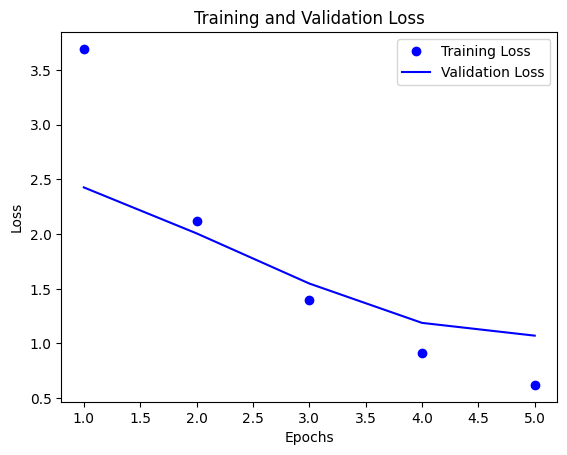

In [11]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 5)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 1s 4ms/step
BiLSTM Model Accuracy :  0.8136363636363636
Precision :  0.8947368421052632
Recall :  0.7786259541984732
F1 :  0.8326530612244899
G-mean: 0.8207573816147398
Training time:  13.586853504180908
Inference time:  0.7487163543701172
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        89
           1       0.89      0.78      0.83       131

    accuracy                           0.81       220
   macro avg       0.81      0.82      0.81       220
weighted avg       0.83      0.81      0.82       220



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


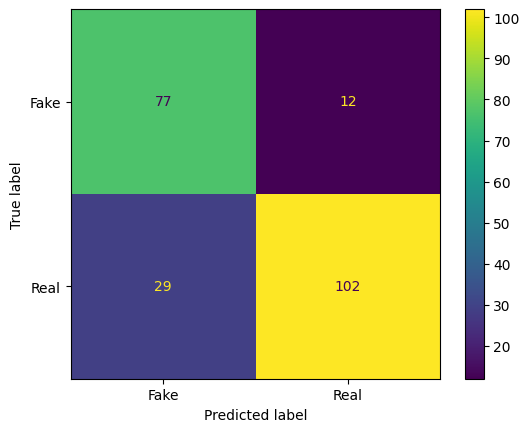

In [12]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()